In [3]:
from calculate_scores import *

total cores: 256
1 Physical GPUs, 1 Logical GPUs


2024-02-22 08:30:24.215571: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:214] Using CUDA malloc Async allocator for GPU: 0
2024-02-22 08:30:24.215798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9063 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:25:00.0, compute capability: 7.5


In [4]:
bands=[29]
patch_size = 128
last_filter = 128
strides = 32    #patch_size
dates, times, labeled_data, x_cao, masks_cao, lon_lats_cao , max_vals, min_vals  = import_label_data("/uio/hume/student-u37/fslippe/data/labeled_data/results_backup_20240221")  
autoencoder_predict = SimpleAutoencoder(len(bands), patch_size, patch_size)

patches_cao, all_lon_patches_cao, all_lat_patches_cao, starts_cao, ends_cao, shapes_cao, n_patches_tot_cao, indices_cao = generate_patches([x[:,:,0] for x in x_cao],
                                                                                                                                            masks_cao,
                                                                                                                                            lon_lats_cao,
                                                                                                                                            max_vals,
                                                                                                                                            min_vals,
                                                                                                                                            autoencoder_predict,
                                                                                                                                            strides=[1, strides, strides,1])



In [ ]:
dates, times, labeled_data, x_cao, masks_cao, lon_lats_cao , max_vals, min_vals  = import_label_data("/uio/hume/student-u37/fslippe/data/labeled_data/results_backup_20240221")  



In [5]:
labeled_data['created_at'] = pd.to_datetime(labeled_data['created_at'])

# Define the cutoff time
cutoff_time = pd.Timestamp('2024-02-01', tz='UTC')  # Specify UTC timezone


# Split the DataFrame
before_cutoff = labeled_data[labeled_data['created_at'] < cutoff_time]
after_cutoff = labeled_data[labeled_data['created_at'] >= cutoff_time]

# Convert DataFrames back to JSON format
before_cutoff_json = before_cutoff.to_json(orient='records')
after_cutoff_json = after_cutoff.to_json(orient='records')


# Save the JSON files
with open("/uio/hume/student-u37/fslippe/data/labeled_data/lavterskel.json", 'w') as f_before:
    f_before.write(before_cutoff_json)

with open("/uio/hume/student-u37/fslippe/data/labeled_data/expert_group.json", 'w') as f_after:
    f_after.write(after_cutoff_json)


In [6]:
last_filter = 32
with tf.device('/CPU:0'):   
    encoded_patches_flat_cao = load_and_predict_encoder(patch_size, last_filter, patches_cao)


In [9]:
import functions 
importlib.reload(functions)
from functions import * 
import calculate_scores 
importlib.reload(calculate_scores)
from calculate_scores import * 
size_threshold = 0
labeled_data = before_cutoff

index_list = range(len(x_cao))
for n_K in [10, 11, 12, 13, 14, 15, 16]:#, 11, 12, 13, 14, 15, 16]:
    open_label = np.load(f"/uio/hume/student-u37/fslippe/data/models/patch_size{patch_size}/filter{last_filter}/clustering/cluster_dnb_l95_z50_ps{patch_size}_band29_filter{last_filter}_K{n_K}_opencell_label.npy")
    closed_label = np.load(f"/uio/hume/student-u37/fslippe/data/models/patch_size{patch_size}/filter{last_filter}/clustering/cluster_dnb_l95_z50_ps{patch_size}_band29_filter{last_filter}_K{n_K}_closedcell_label.npy")
    
    print("open", open_label)
    print("closed", closed_label)

    if not os.path.exists(f"/uio/hume/student-u37/fslippe/data/models/patch_size{patch_size}/filter{last_filter}/clustering/cluster_dnb_l95_z50_ps{patch_size}_band29_filter{last_filter}_K{n_K}_opencell_label.npy"):
        manually_find_cloud_labels(min_vals, max_vals, autoencoder_predict, patch_size, last_filter, n_K)
    if not os.path.exists(f"/uio/hume/student-u37/fslippe/data/models/patch_size{patch_size}/filter{last_filter}/clustering/cluster_dnb_l95_z50_ps{patch_size}_band29_filter{last_filter}_K{n_K}_closedcell_label.npy"):
        manually_find_cloud_labels(min_vals, max_vals, autoencoder_predict, patch_size, last_filter, n_K)

    open_label = np.load(f"/uio/hume/student-u37/fslippe/data/models/patch_size{patch_size}/filter{last_filter}/clustering/cluster_dnb_l95_z50_ps{patch_size}_band29_filter{last_filter}_K{n_K}_opencell_label.npy")
    closed_label = np.load(f"/uio/hume/student-u37/fslippe/data/models/patch_size{patch_size}/filter{last_filter}/clustering/cluster_dnb_l95_z50_ps{patch_size}_band29_filter{last_filter}_K{n_K}_closedcell_label.npy")
    
    
    labels, global_min, global_max = get_cluster_results(encoded_patches_flat_cao, patch_size, last_filter, n_K)
    print(global_max)
    
    label_map, lon_map, lat_map = process_label_maps(labels,
                                                    all_lon_patches_cao,
                                                    all_lat_patches_cao,
                                                    starts_cao,                 
                                                    ends_cao,
                                                    shapes_cao,         
                                                    indices_cao,
                                                    global_max,             
                                                    n_patches_tot_cao,              
                                                    patch_size,
                                                    strides,
                                                    closed_label, 
                                                    open_label, 
                                                    size_thr_1=size_threshold, 
                                                    size_thr_2=size_threshold)

        # Example usage of the function
    extent = [-15, 25, 58, 84]
    # plot_filtered_map(label_map, lon_map, lat_map, idx, extent, global_max, dates)
    # plt.show()
    valid_lons = []
    valid_lats = []

    for i in index_list:
        valid_lon, valid_lat = get_valid_lons_lats(x_cao[i][:,:,0],
                                                    lon_lats_cao[i],
                                                    label_map[i],
                                                    lon_map[i],
                                                    lat_map[i],
                                                    dates[i],
                                                    times[i],
                                                    open_label=closed_label,
                                                    closed_label=open_label,
                                                    p_level=950,
                                                    angle_thr=5,
                                                    size_threshold_1=None,
                                                    size_threshold_2=None,
                                                    plot=False,
                                                    extent= [-15, 25, 58, 84])
        valid_lons.append(valid_lon)
        valid_lats.append(valid_lat)                                            


    model_borders, model_areas = process_model_masks(index_list, lon_map, lat_map, valid_lons, valid_lats, indices_cao, label_map, closed_label, open_label, brush=False, plot=False)

    labeled_areas, labeled_borders = get_area_and_border_mask(x_cao, dates, times, masks_cao, labeled_data, reduction=strides, index_list=index_list, plot=False)



    # cmap_tab10 = plt.cm.tab10
    # cmap_tab20 = plt.cm.tab20
    # colors_tab20 = cmap_tab20(np.arange(cmap_tab20.N))[1::2]
    # colors_tab10 = cmap_tab10(np.arange(cmap_tab10.N))
    # extra_colors = colors_tab20
    # black = np.array([0, 0, 0, 1])
    # colors_new = np.vstack((colors_tab10, colors_tab20))[:np.max(global_max)-1]
    # colors_new = np.vstack((colors_new, black))
    # label_cmap = mcolors.ListedColormap(colors_new)

    # for i in index_list:
    #     plot_areas_w_scores(x_cao[i], label_map[i], label_cmap, labeled_areas[i], model_areas[i], area_scores[i], weighted_area_scores[i])
    # fig, axs = plt.subplots(1,2, figsize=[10,10])
    # cb = axs[0].imshow(labeled_areas[0])
    # plt.colorbar(cb)
    # cb = axs[1].imshow(labeled_borders[0])
    # plt.colorbar(cb)


    all_area_scores, all_border_scores= calculate_scores_and_plot(model_borders, model_areas, labeled_borders, labeled_areas, plot=False)

    
    folder = f"/uio/hume/student-u37/fslippe/data/models/patch_size{patch_size}/filter{last_filter}/clustering/scores/"
    if not os.path.exists(folder):
        os.makedirs(folder)

    np.save(folder + f"area_scores_cluster_dnb_l95_z50_ps{patch_size}_band29_filter{last_filter}_K{n_K}_res{strides}_thr{size_threshold}_only_lavterskel", all_area_scores)
    np.save(folder + f"border_scores_cluster_dnb_l95_z50_ps{patch_size}_band29_filter{last_filter}_K{n_K}_res{strides}_thr{size_threshold}_only_lavterskel", all_border_scores)
    

1 Physical GPUs, 1 Logical GPUs
open 6
closed 5
cluster load loc: /uio/hume/student-u37/fslippe/data/models/patch_size128/filter32/clustering/cluster_dnb_l95_z50_ps128_band29_filter32_K10.pkl
10


/uio/hume/student-u37/fslippe/master_project/code/functions.py:319: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pat_lon = np.concatenate(np.array(pat_lon), axis=0)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:320: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pat_lat = np.concatenate(np.array(pat_lat), axis=0)


2019072 1230
2019318 1155
2019286 1155
2021030 1135
2019053 1200
2020081 1155
2022061 1150
2019018 1130
2019018 950
2020289 1155
2019060 1030
2020358 855
2022110 1055
2020024 845
2019049 1225
2019027 1300
2022349 1135
2019110 1155
2020023 2100
2020034 1100
2022352 1340
2022347 1150
2019045 1110
2023022 1130
2022120 955
2022070 1145
2022095 1140
2021003 1155
2023080 1015
2020328 1200
2022100 1335
2023040 1045


/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, 

2019094 1155
2019065 1045
2021362 1330
2020040 1020
2022278 1140
2022027 1205
2020064 1250
2019080 1140
2019017 1225
2022299 1140


/uio/hume/student-u37/fslippe/master_project/code/functions.py:643: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  area_lines = np.array(di["data.areaLines"])
/uio/hume/student-u37/fslippe/master_project/code/functions.py:453: RuntimeWarning: invalid value encountered in true_divide
  border_weighted_frac = np.where(m_preds, abs(m_border - l_border) / tot_border_preds, np.nan)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:454: RuntimeWarning: invalid value encountered in true_divide
  border_frac = np.where(m_preds, abs(m_border - l_yes_no_border) / tot_border_preds, np.nan)


open 3
closed 9
cluster load loc: /uio/hume/student-u37/fslippe/data/models/patch_size128/filter32/clustering/cluster_dnb_l95_z50_ps128_band29_filter32_K11.pkl
11


/uio/hume/student-u37/fslippe/master_project/code/functions.py:319: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pat_lon = np.concatenate(np.array(pat_lon), axis=0)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:320: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pat_lat = np.concatenate(np.array(pat_lat), axis=0)


2019072 1230
2019318 1155
2019286 1155
2021030 1135
2019053 1200
2020081 1155
2022061 1150
2019018 1130
2019018 950
2020289 1155
2019060 1030
2020358 855
2022110 1055
2020024 845
2019049 1225
2019027 1300
2022349 1135
2019110 1155
2020023 2100
2020034 1100
2022352 1340
2022347 1150
2019045 1110
2023022 1130
2022120 955
2022070 1145
2022095 1140
2021003 1155
2023080 1015
2020328 1200
2022100 1335
2023040 1045
2019094 1155
2019065 1045
2021362 1330
2020040 1020
2022278 1140
2022027 1205
2020064 1250
2019080 1140
2019017 1225
2022299 1140


/uio/hume/student-u37/fslippe/master_project/code/functions.py:643: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  area_lines = np.array(di["data.areaLines"])
/uio/hume/student-u37/fslippe/master_project/code/functions.py:453: RuntimeWarning: divide by zero encountered in true_divide
  border_weighted_frac = np.where(m_preds, abs(m_border - l_border) / tot_border_preds, np.nan)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:453: RuntimeWarning: invalid value encountered in true_divide
  border_weighted_frac = np.where(m_preds, abs(m_border - l_border) / tot_border_preds, np.nan)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:454: RuntimeWarning: divide by zero encountered in true_divide
  border_frac = np.where(m_preds, abs(m_border - l_

open 7
closed 9
cluster load loc: /uio/hume/student-u37/fslippe/data/models/patch_size128/filter32/clustering/cluster_dnb_l95_z50_ps128_band29_filter32_K12.pkl
12


/uio/hume/student-u37/fslippe/master_project/code/functions.py:319: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pat_lon = np.concatenate(np.array(pat_lon), axis=0)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:320: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pat_lat = np.concatenate(np.array(pat_lat), axis=0)


2019072 1230
2019318 1155
2019286 1155
2021030 1135
2019053 1200
2020081 1155
2022061 1150
2019018 1130
2019018 950
2020289 1155
2019060 1030
2020358 855
2022110 1055
2020024 845
2019049 1225
2019027 1300
2022349 1135
2019110 1155
2020023 2100
2020034 1100
2022352 1340
2022347 1150
2019045 1110
2023022 1130
2022120 955
2022070 1145
2022095 1140
2021003 1155
2023080 1015
2020328 1200
2022100 1335
2023040 1045


/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, 

2019094 1155
2019065 1045
2021362 1330
2020040 1020
2022278 1140
2022027 1205
2020064 1250
2019080 1140
2019017 1225
2022299 1140


/uio/hume/student-u37/fslippe/master_project/code/functions.py:643: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  area_lines = np.array(di["data.areaLines"])


open 2
closed 10
cluster load loc: /uio/hume/student-u37/fslippe/data/models/patch_size128/filter32/clustering/cluster_dnb_l95_z50_ps128_band29_filter32_K13.pkl
13


/uio/hume/student-u37/fslippe/master_project/code/functions.py:319: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pat_lon = np.concatenate(np.array(pat_lon), axis=0)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:320: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pat_lat = np.concatenate(np.array(pat_lat), axis=0)


2019072 1230
2019318 1155
2019286 1155
2021030 1135
2019053 1200
2020081 1155
2022061 1150
2019018 1130
2019018 950
2020289 1155
2019060 1030
2020358 855
2022110 1055
2020024 845
2019049 1225
2019027 1300
2022349 1135
2019110 1155
2020023 2100
2020034 1100
2022352 1340
2022347 1150
2019045 1110
2023022 1130
2022120 955
2022070 1145
2022095 1140
2021003 1155
2023080 1015
2020328 1200
2022100 1335
2023040 1045
2019094 1155
2019065 1045
2021362 1330
2020040 1020
2022278 1140
2022027 1205
2020064 1250
2019080 1140
2019017 1225
2022299 1140


/uio/hume/student-u37/fslippe/master_project/code/functions.py:643: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  area_lines = np.array(di["data.areaLines"])
/uio/hume/student-u37/fslippe/master_project/code/functions.py:453: RuntimeWarning: divide by zero encountered in true_divide
  border_weighted_frac = np.where(m_preds, abs(m_border - l_border) / tot_border_preds, np.nan)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:453: RuntimeWarning: invalid value encountered in true_divide
  border_weighted_frac = np.where(m_preds, abs(m_border - l_border) / tot_border_preds, np.nan)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:454: RuntimeWarning: divide by zero encountered in true_divide
  border_frac = np.where(m_preds, abs(m_border - l_

open 4
closed 2
cluster load loc: /uio/hume/student-u37/fslippe/data/models/patch_size128/filter32/clustering/cluster_dnb_l95_z50_ps128_band29_filter32_K14.pkl
14


/uio/hume/student-u37/fslippe/master_project/code/functions.py:319: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pat_lon = np.concatenate(np.array(pat_lon), axis=0)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:320: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pat_lat = np.concatenate(np.array(pat_lat), axis=0)


2019072 1230
2019318 1155
2019286 1155
2021030 1135
2019053 1200
2020081 1155
2022061 1150
2019018 1130
2019018 950
2020289 1155
2019060 1030
2020358 855
2022110 1055
2020024 845
2019049 1225
2019027 1300
2022349 1135
2019110 1155
2020023 2100
2020034 1100
2022352 1340
2022347 1150
2019045 1110
2023022 1130
2022120 955
2022070 1145
2022095 1140
2021003 1155
2023080 1015
2020328 1200
2022100 1335
2023040 1045


/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)


2019094 1155
2019065 1045
2021362 1330
2020040 1020
2022278 1140
2022027 1205
2020064 1250
2019080 1140
2019017 1225
2022299 1140


/uio/hume/student-u37/fslippe/master_project/code/functions.py:643: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  area_lines = np.array(di["data.areaLines"])
/uio/hume/student-u37/fslippe/master_project/code/functions.py:453: RuntimeWarning: divide by zero encountered in true_divide
  border_weighted_frac = np.where(m_preds, abs(m_border - l_border) / tot_border_preds, np.nan)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:453: RuntimeWarning: invalid value encountered in true_divide
  border_weighted_frac = np.where(m_preds, abs(m_border - l_border) / tot_border_preds, np.nan)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:454: RuntimeWarning: divide by zero encountered in true_divide
  border_frac = np.where(m_preds, abs(m_border - l_

open 1
closed 8
cluster load loc: /uio/hume/student-u37/fslippe/data/models/patch_size128/filter32/clustering/cluster_dnb_l95_z50_ps128_band29_filter32_K15.pkl
15


/uio/hume/student-u37/fslippe/master_project/code/functions.py:319: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pat_lon = np.concatenate(np.array(pat_lon), axis=0)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:320: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pat_lat = np.concatenate(np.array(pat_lat), axis=0)


2019072 1230
2019318 1155
2019286 1155
2021030 1135
2019053 1200
2020081 1155
2022061 1150
2019018 1130
2019018 950
2020289 1155
2019060 1030
2020358 855
2022110 1055
2020024 845
2019049 1225
2019027 1300
2022349 1135
2019110 1155
2020023 2100
2020034 1100
2022352 1340
2022347 1150
2019045 1110
2023022 1130
2022120 955
2022070 1145
2022095 1140
2021003 1155
2023080 1015
2020328 1200
2022100 1335
2023040 1045


/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, 

2019094 1155
2019065 1045
2021362 1330
2020040 1020
2022278 1140
2022027 1205
2020064 1250
2019080 1140
2019017 1225
2022299 1140


/uio/hume/student-u37/fslippe/master_project/code/functions.py:643: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  area_lines = np.array(di["data.areaLines"])


open 10
closed 11
cluster load loc: /uio/hume/student-u37/fslippe/data/models/patch_size128/filter32/clustering/cluster_dnb_l95_z50_ps128_band29_filter32_K16.pkl
16


/uio/hume/student-u37/fslippe/master_project/code/functions.py:319: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pat_lon = np.concatenate(np.array(pat_lon), axis=0)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:320: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pat_lat = np.concatenate(np.array(pat_lat), axis=0)


2019072 1230
2019318 1155
2019286 1155
2021030 1135
2019053 1200
2020081 1155
2022061 1150
2019018 1130
2019018 950
2020289 1155
2019060 1030
2020358 855
2022110 1055
2020024 845
2019049 1225
2019027 1300
2022349 1135
2019110 1155
2020023 2100
2020034 1100
2022352 1340
2022347 1150
2019045 1110
2023022 1130
2022120 955
2022070 1145
2022095 1140
2021003 1155
2023080 1015
2020328 1200
2022100 1335
2023040 1045


/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)
/uio/hume/student-u37/fslippe/master_project/code/functions.py:975: RuntimeWarning: invalid value encountered in remainder
  lon, lat, (wind_direction) % 360, step_distance)


2019094 1155
2019065 1045
2021362 1330
2020040 1020
2022278 1140
2022027 1205
2020064 1250
2019080 1140
2019017 1225
2022299 1140


/uio/hume/student-u37/fslippe/master_project/code/functions.py:643: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  area_lines = np.array(di["data.areaLines"])


In [94]:
print(all_area_scores.keys())

for key, item in all_area_scores.items():
    print(key, np.mean(item)/ np.mean(all_area_scores["tot_points"]))

dict_keys(['tot_points', 'area_tot_labeled', 'area_scores', 'weighted_area_scores', 'area_true_positive_scores', 'area_false_positive_scores', 'area_true_negative_scores', 'area_false_negative_scores', 'area_true_prediction_scores', 'area_false_prediction_scores'])
tot_points 1.0
area_tot_labeled 0.23239063247597988
area_scores 0.0004773150031965806
weighted_area_scores 0.0003413065576512049
area_true_positive_scores 0.06575629437095085
area_false_positive_scores 0.01915143991413534
area_true_negative_scores 0.7484579276098848
area_false_negative_scores 0.166634338105029
area_true_prediction_scores 0.8142142219808356
area_false_prediction_scores 0.18578577801916435


In [95]:
cmap_tab10 = plt.cm.tab10
cmap_tab20 = plt.cm.tab20
colors_tab20 = cmap_tab20(np.arange(cmap_tab20.N))[1::2]
colors_tab10 = cmap_tab10(np.arange(cmap_tab10.N))
extra_colors = colors_tab20
black = np.array([0, 0, 0, 1])
colors_new = np.vstack((colors_tab10, colors_tab20))[:np.max(global_max)-1]
colors_new = np.vstack((colors_new, black))
label_cmap = mcolors.ListedColormap(colors_new)


def plot_areas_w_scores(x_cao, label_map, label_cmap, labeled_area, model_area, score, weighted_score):
    fig, axs = plt.subplots(1, 4, figsize=[20,10])
    fig.suptitle("Score: %.4f    Weighted score %.4f" %(score, weighted_score))

    cb = axs[0].imshow(x_cao, cmap="gray_r")
    plt.colorbar(cb)

    cb = axs[1].imshow(label_map, cmap=label_cmap)
    plt.colorbar(cb)

    axs[2].set_title("Labeled area")
    cb = axs[2].imshow(labeled_area, vmin=0, vmax=1)
    plt.colorbar(cb)

    axs[3].set_title("Model area")
    cb = axs[3].imshow(model_area, vmin=0, vmax=1)
    plt.colorbar(cb)
    
    plt.show()

def plot_borders_w_scores(x_cao, label_map, label_cmap, labeled_border, model_border, score, weighted_score):
    fig, axs = plt.subplots(1, 4, figsize=[20,10])
    fig.suptitle("Score: %.4f    Weighted score %.4f" %(score, weighted_score))

    cb = axs[0].imshow(x_cao, cmap="gray_r")
    plt.colorbar(cb)

    cb = axs[1].imshow(label_map, cmap=label_cmap)
    plt.colorbar(cb)

    axs[2].set_title("Labeled border")
    cb = axs[2].imshow(labeled_border, vmin=0, vmax=1)
    plt.colorbar(cb)

    axs[3].set_title("Model border")
    cb = axs[3].imshow(model_border, vmin=0, vmax=1)
    plt.colorbar(cb)

    plt.show()

for i in index_list:
    plot_areas_w_scores(x_cao[i], label_map[i], label_cmap, labeled_areas[i], model_areas[i], area_scores[i], weighted_area_scores[i])
    #plot_borders_w_scores(x_cao[i], label_map[i], label_cmap, labeled_borders[i], model_borders[i], border_scores[i], weighted_border_scores[i])




NameError: name 'area_scores' is not defined

In [ ]:
cmap_tab10 = plt.cm.tab10
cmap_tab20 = plt.cm.tab20
colors_tab20 = cmap_tab20(np.arange(cmap_tab20.N))[1::2]
colors_tab10 = cmap_tab10(np.arange(cmap_tab10.N))
extra_colors = colors_tab20
black = np.array([0, 0, 0, 1])
colors_new = np.vstack((colors_tab10, colors_tab20))[:np.max(global_max)-1]
colors_new = np.vstack((colors_new, black))

new_cmap = mcolors.ListedColormap(colors_new)
label_map, lon_map, lat_map = process_label_maps(labels,
                                                    all_lon_patches_cao,
                                                    all_lat_patches_cao,
                                                    starts_cao,
                                                    ends_cao,
                                                    shapes_cao,
                                                    indices_cao,
                                                    global_max,
                                                    n_patches_tot_cao,
                                                    patch_size,
                                                    strides,
                                                    closed_label, 
                                                    open_label, 
                                                    size_thr_1=0, 
                                                    size_thr_2=0)
for i in range(0, 30):
    print(np.load(f"/uio/hume/student-u37/fslippe/data/models/patch_size128/filter{last_filter}/clustering/cluster_dnb_l95_z50_ps128_band29_filter{last_filter}_K{n_K}_opencell_label.npy"))
    print(np.load(f"/uio/hume/student-u37/fslippe/data/models/patch_size128/filter{last_filter}/clustering/cluster_dnb_l95_z50_ps128_band29_filter{last_filter}_K{n_K}_closedcell_label.npy"))

    fig, axs = plt.subplots(1, 2, figsize=[10,10])
    axs[0].imshow(x_cao[i], cmap="gray_r")
    cb = axs[1].imshow(label_map[i], cmap=new_cmap)
    plt.colorbar(cb)
    plt.show()

[75.1457748413086, 74.6221923828125, 74.49290466308594, 74.39938354492188, 74.01485443115234, 74.11624145507812, 74.29517364501953, 74.18830108642578, 74.04277801513672, 74.08292388916016, 74.1897964477539, 73.23744201660156, 76.10464477539062, 76.02870178222656, 75.95052337646484, 73.31794738769531, 72.75251770019531, 75.60894775390625, 75.53550720214844, 75.45989227294922, 75.38550567626953, 75.46112060546875, 75.30873107910156, 75.23318481445312, 75.3099594116211, 75.15501403808594, 74.75713348388672, 74.83898162841797, 74.67292785644531, 74.58998107910156, 74.67417907714844, 74.50302124023438, 73.31942749023438, 74.91243743896484, 75.81283569335938, 75.67898559570312, 75.54373168945312, 73.70452880859375, 73.6244888305664, 73.76211547851562, 73.4866943359375, 70.810546875]


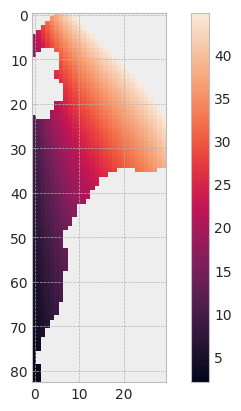

[[      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 ...
 [2.236812  3.2787712       nan ...       nan       nan       nan]
 [2.1439664 3.176776        nan ...       nan       nan       nan]
 [2.0521848 3.076049        nan ...       nan       nan       nan]]
[[      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 ...
 [2.236812  3.2787712       nan ...       nan       nan       nan]
 [2.1439664 3.176776        nan ...       nan       nan       nan]
 [2.0521848 3.076049        nan ...       nan       nan       nan]]


[39.17970657348633, 40.638145446777344, 42.76261901855469, 41.55586242675781, 43.796302795410156, 44.174339294433594, 41.187503814697266, 40.829490661621094, 42.951194763183594, 40.4

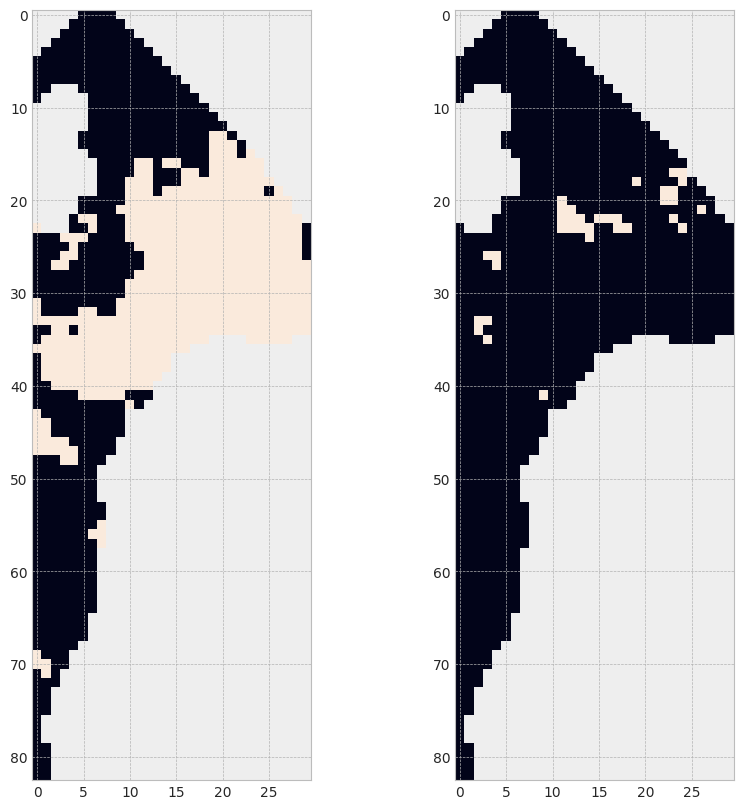

In [ ]:
index_list = [10]

import functions 
importlib.reload(functions)
from functions import *
# label_map, lon_map, lat_map = process_label_maps(labels,
#                                                     all_lon_patches_cao,
#                                                     all_lat_patches_cao,
#                                                     starts_cao,
#                                                     ends_cao,
#                                                     shapes_cao,
#                                                     indices_cao,
#                                                     global_max,
#                                                     n_patches_tot_cao,
#                                                     patch_size,
#                                                     strides,
#                                                     closed_label, 
#                                                     open_label, 
#                                                     size_thr_1=20, 
#                                                     size_thr_2=20)

    # Example usage of the function
extent = [-15, 25, 58, 84]
# plot_filtered_map(label_map, lon_map, lat_map, idx, extent, global_max, dates)
# plt.show()
# valid_lons = np.empty(index_list[-1]+1, dtype=object)
# valid_lats = np.empty(index_list[-1]+1, dtype=object)

# for i in index_list:
#     plt.imshow(masks_cao[i])
#     plt.show()
#     plt.imshow(label_map[i], cmap="tab10")
#     plt.colorbar()
#     plt.show()
#     plt.imshow(x_cao[i], cmap="gray_r")
#     plt.show()
#     valid_lon, valid_lat = get_valid_lons_lats(x_cao[i][:,:,0],
#                                                 lon_lats_cao[i],
#                                                 label_map[i],
#                                                 lon_map[i],
#                                                 lat_map[i],
#                                                 dates[i],
#                                                 times[i],
#                                                 open_label=closed_label,
#                                                 closed_label=open_label,
#                                                 p_level=950,
#                                                 angle_thr=5,
#                                                 size_threshold_1=None,
#                                                 size_threshold_2=None,
#                                                 plot=True,
#                                                 extent= [-15, 25, 58, 84])
#     valid_lons[i] = (valid_lon)
#     valid_lats[i] = (valid_lat)

model_boundaries, model_areas = process_model_masks(index_list, lon_map, lat_map, valid_lons, valid_lats, indices_cao, label_map, closed_label, open_label, brush=False, plot=True)
#model_borders, model_areas = process_model_masks(index_list, lon_map, lat_map, valid_lons, valid_lats, indices_cao, label_map, closed_label, open_label, brush=False, plot=False)

dates_idx = [dates[idx] for idx in index_list]
times_idx = [times[idx] for idx in index_list]

#labeled_areas, labeled_boundaries = get_area_and_border_mask(x_cao, dates, times, masks_cao, labeled_data, reduction=strides, index_list=index_list, plot=True)
# fig, axs = plt.subplots(1,2, figsize=[10,10])
# cb = axs[0].imshow(labeled_areas[0])
# plt.colorbar(cb)
# cb = axs[1].imshow(labeled_boundaries[0])
# plt.colorbar(cb)


#area_scores, border_scores, weighted_area_score, weighted_border_score = calculate_scores_and_plot(model_boundaries, model_areas, labeled_boundaries, labeled_areas, plot=True)

In [ ]:
bands=[29]
patch_size = 128
last_filter = 128
strides = 32    #patch_size
dates, times, labeled_data, x_cao, masks_cao, lon_lats_cao , max_vals, min_vals  = import_label_data("/uio/hume/student-u37/fslippe/data/labeled_data/results_backup_20240221")  
autoencoder_predict = SimpleAutoencoder(len(bands), patch_size, patch_size)

patches_cao, all_lon_patches_cao, all_lat_patches_cao, starts_cao, ends_cao, shapes_cao, n_patches_tot_cao, indices_cao = generate_patches([x[:,:,0] for x in x_cao],
                                                                                                                                            masks_cao,
                                                                                                                                            lon_lats_cao,
                                                                                                                                            max_vals,
                                                                                                                                            min_vals,
                                                                                                                                            autoencoder_predict,
                                                                                                                                            strides=[1, strides, strides,1])



In [ ]:
labeled_data['created_at'] = pd.to_datetime(labeled_data['created_at'])

# Define the cutoff time
cutoff_time = pd.Timestamp('2024-02-01', tz='UTC')  # Specify UTC timezone


# Split the DataFrame
before_cutoff = labeled_data[labeled_data['created_at'] < cutoff_time]
after_cutoff = labeled_data[labeled_data['created_at'] >= cutoff_time]

# Convert DataFrames back to JSON format
before_cutoff_json = before_cutoff.to_json(orient='records')
after_cutoff_json = after_cutoff.to_json(orient='records')


# Save the JSON files
with open("/uio/hume/student-u37/fslippe/data/labeled_data/lavterskel.json", 'w') as f_before:
    f_before.write(before_cutoff_json)

with open("/uio/hume/student-u37/fslippe/data/labeled_data/expert_group.json", 'w') as f_after:
    f_after.write(after_cutoff_json)


Files have been split and saved.


In [ ]:
bands=[29]
patch_size = 128
last_filter = 128
strides = 32    #patch_size
dates, times, labeled_data, x_cao, masks_cao, lon_lats_cao , max_vals, min_vals  = import_label_data("/uio/hume/student-u37/fslippe/data/labeled_data/results_backup_20240221")  
autoencoder_predict = SimpleAutoencoder(len(bands), patch_size, patch_size)

patches_cao, all_lon_patches_cao, all_lat_patches_cao, starts_cao, ends_cao, shapes_cao, n_patches_tot_cao, indices_cao = generate_patches([x[:,:,0] for x in x_cao],
                                                                                                                                            masks_cao,
                                                                                                                                            lon_lats_cao,
                                                                                                                                            max_vals,
                                                                                                                                            min_vals,
                                                                                                                                            autoencoder_predict,
                                                                                                                                            strides=[1, strides, strides,1])



In [ ]:
labeled_data['created_at'] = pd.to_datetime(labeled_data['created_at'])

# Define the cutoff time
cutoff_time = pd.Timestamp('2024-02-01', tz='UTC')  # Specify UTC timezone


# Split the DataFrame
before_cutoff = labeled_data[labeled_data['created_at'] < cutoff_time]
after_cutoff = labeled_data[labeled_data['created_at'] >= cutoff_time]

# Convert DataFrames back to JSON format
before_cutoff_json = before_cutoff.to_json(orient='records')
after_cutoff_json = after_cutoff.to_json(orient='records')


# Save the JSON files
with open("/uio/hume/student-u37/fslippe/data/labeled_data/lavterskel.json", 'w') as f_before:
    f_before.write(before_cutoff_json)

with open("/uio/hume/student-u37/fslippe/data/labeled_data/expert_group.json", 'w') as f_after:
    f_after.write(after_cutoff_json)


Files have been split and saved.


(42, 15)
(42, 15)
(42, 15)
(42, 15)
(42, 15)
(42, 15)
(42, 15)
(42, 15)
(42, 15)
(42, 15)
(42, 15)
(42, 15)


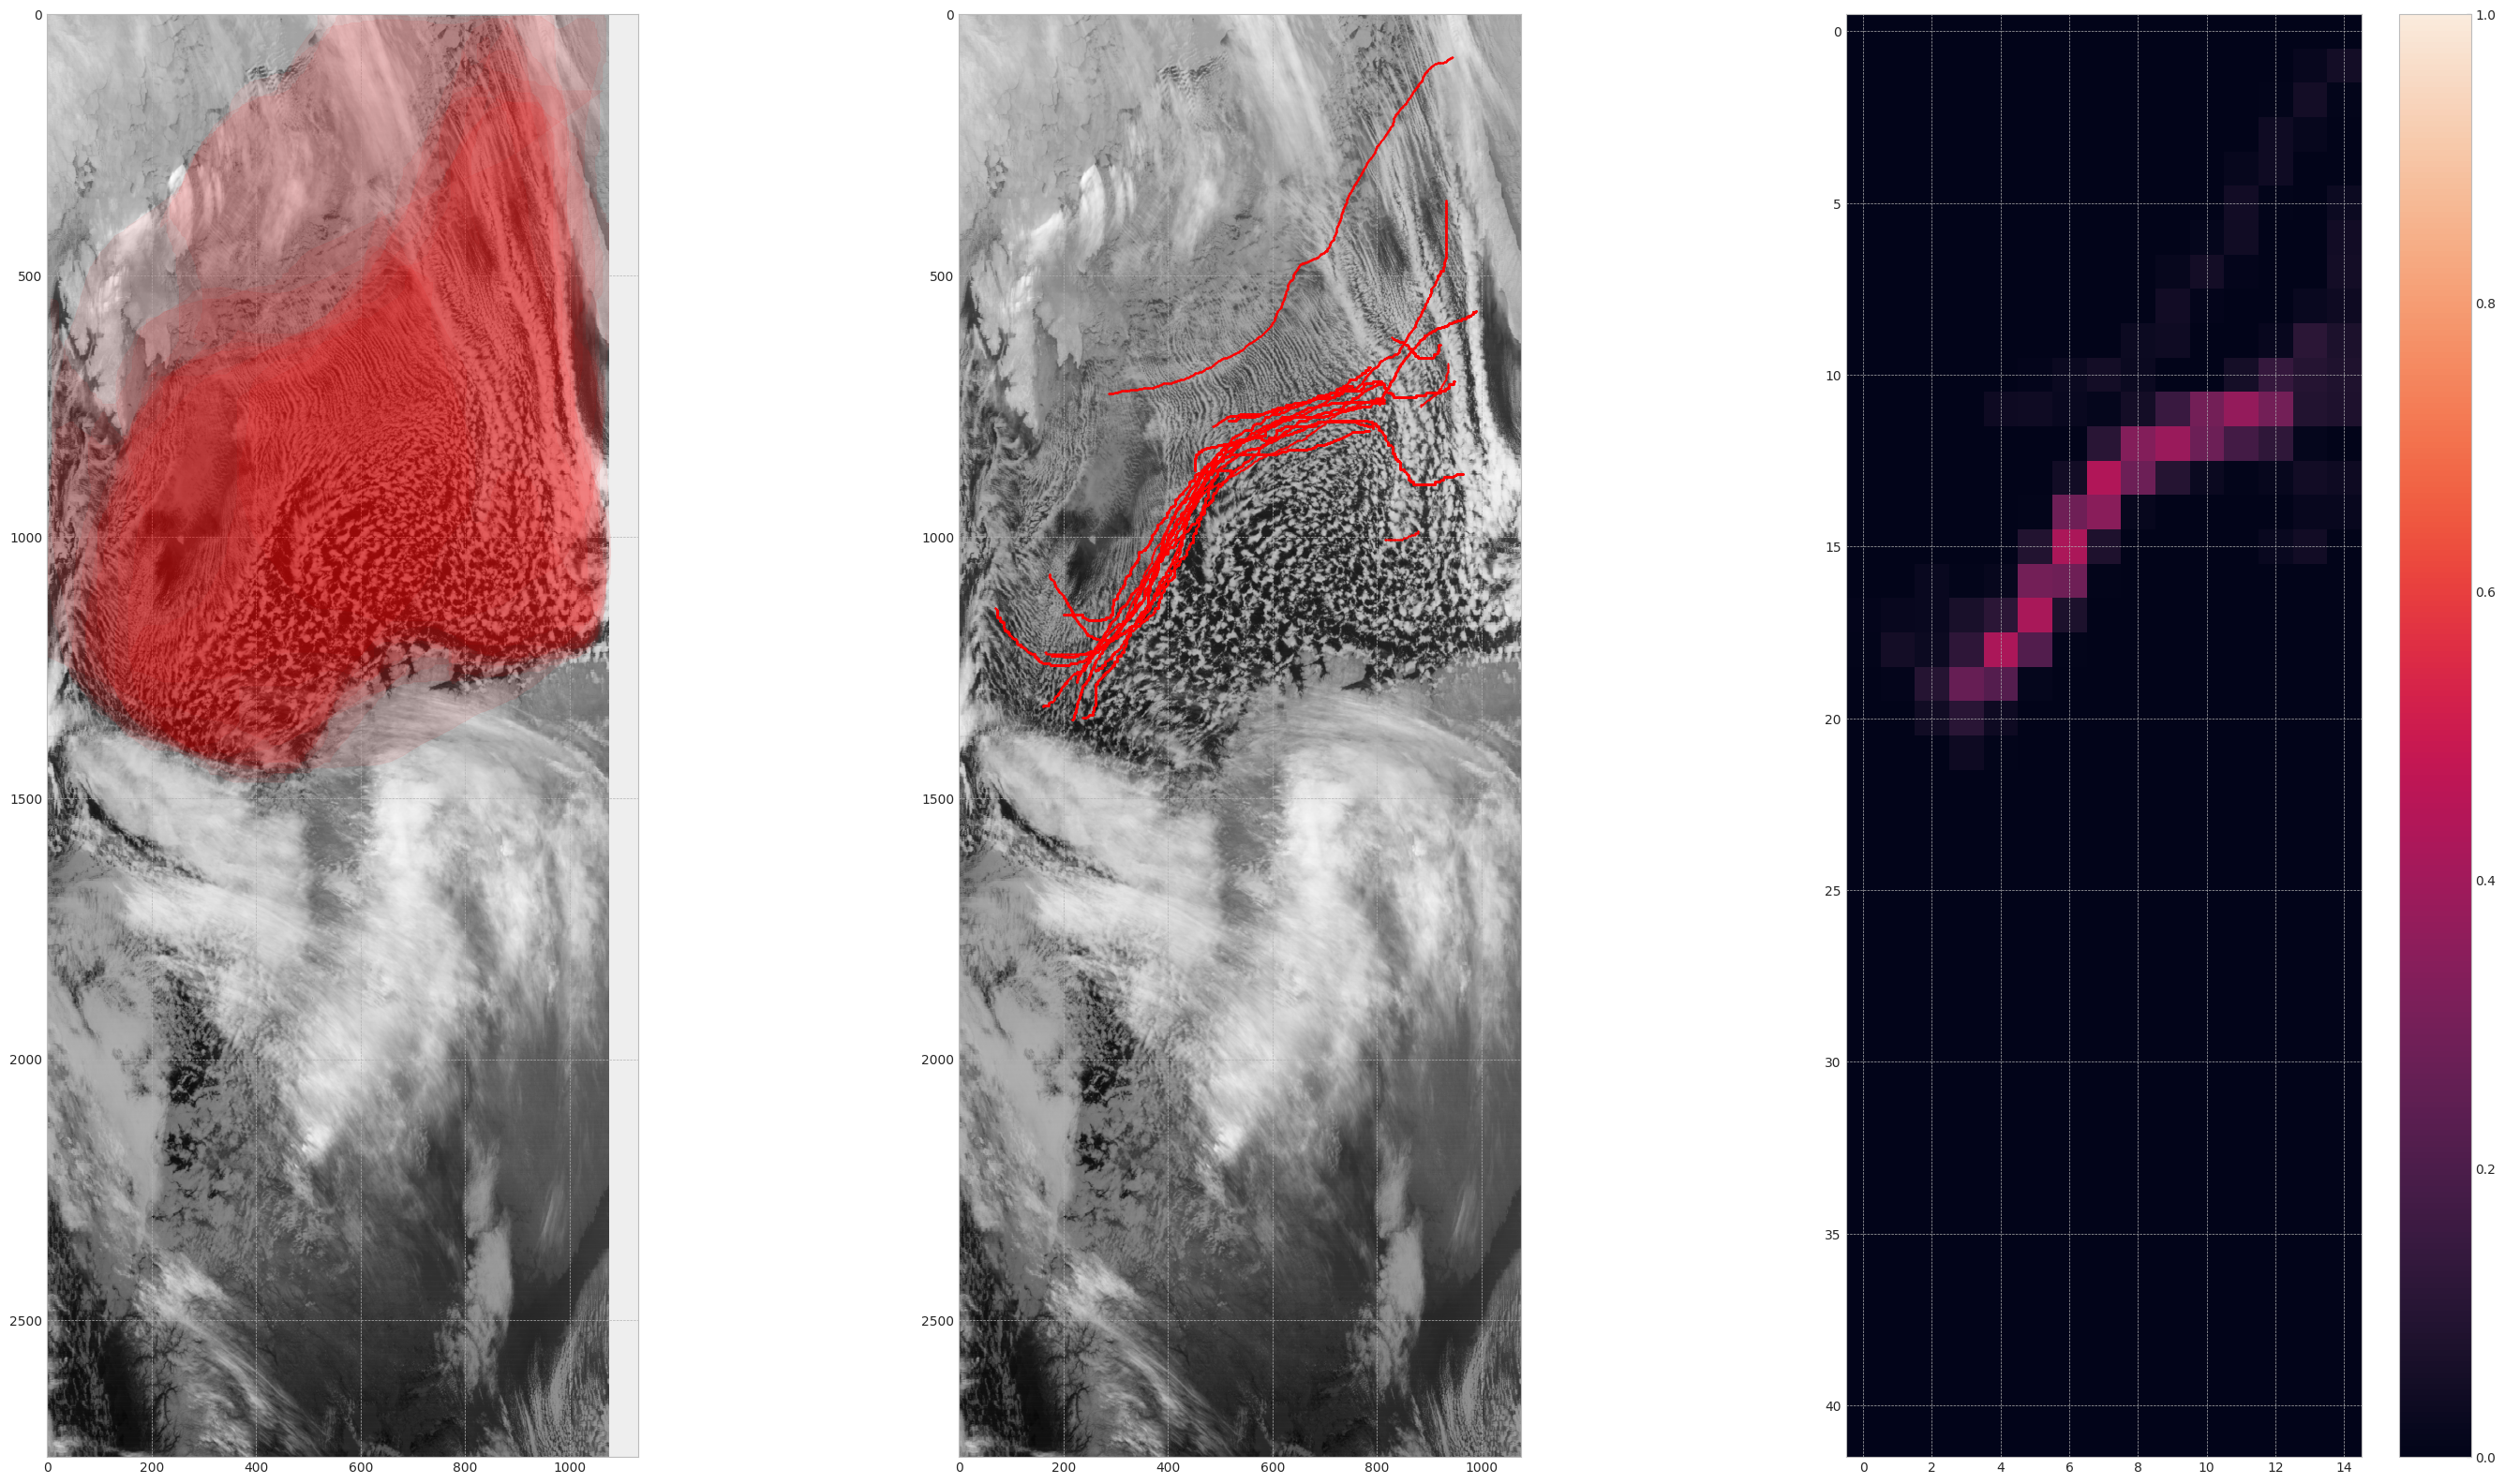

In [ ]:
import functions 
importlib.reload(functions)
from functions import *
labeled_areas, labeled_boundaries = get_area_and_border_mask(x_cao, dates, times, masks_cao, labeled_data, reduction=strides, index_list=index_list, plot=True)
